In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from collections import deque

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
dataset_path = "C:/Users/batuh/Downloads/Compressed/Dataset_3"
actions = os.listdir(dataset_path)

In [3]:
frame_count = 20

frame_width = 64
frame_height = 64

seed_constant = 86
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
def take_video_names(dataset_path):

  actions = os.listdir(dataset_path)
  video_paths = []
  video_labels = []

  for single_action in actions:

    videos = os.listdir(dataset_path + "/" + single_action)

    for single_video in videos:

      single_video_path = dataset_path + "/" + single_action + "/" + single_video

      video_paths.append(single_video_path)
      video_labels.append(single_action)

  print(f"There is {len(actions)} action in the dataset.")
  print(f"There is {len(video_paths)} video in the dataset\n")

  return np.array(video_paths), np.array(video_labels)

In [5]:
def video_preprocess(frame):

  resized_frame = cv2.resize(frame, (frame_height, frame_width))

  normalized_frame = resized_frame / 255

  return normalized_frame

In [6]:
def load_video (video_path):

  frames_list = []

  cap = cv2.VideoCapture(video_path)

  ok, frame = cap.read()

  video_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_ratio = max(int(video_frame_count/frame_count), 1)

  for i in range(frame_count):

    cap.set(cv2.CAP_PROP_POS_FRAMES, i * skip_ratio)

    oke, frame = cap.read()

    if not oke:
      break

    frame = video_preprocess(frame)

    frames_list.append(frame)

  if len(frames_list) != frame_count:
    print(f"There is not enough number of frames in this video {video_path}")

  cap.release()

  return frames_list

In [7]:
feature_s = []

count = 0

videos, labels = take_video_names(dataset_path)

for one_video in videos:

  count = count + 1

  feature_s.append(load_video(one_video))

  print (f"{count/len(videos)*100} percent complete ")

feature_s = np.array(feature_s)

There is 4 action in the dataset.
There is 1776 video in the dataset

0.05630630630630631 percent complete 
0.11261261261261261 percent complete 
0.16891891891891891 percent complete 
0.22522522522522523 percent complete 
0.28153153153153154 percent complete 
0.33783783783783783 percent complete 
0.3941441441441441 percent complete 
0.45045045045045046 percent complete 
0.5067567567567568 percent complete 
0.5630630630630631 percent complete 
0.6193693693693694 percent complete 
0.6756756756756757 percent complete 
0.7319819819819819 percent complete 
0.7882882882882882 percent complete 
0.8445945945945946 percent complete 
0.9009009009009009 percent complete 
0.9572072072072071 percent complete 
1.0135135135135136 percent complete 
1.0698198198198199 percent complete 
1.1261261261261262 percent complete 
1.1824324324324325 percent complete 
1.2387387387387387 percent complete 
1.295045045045045 percent complete 
1.3513513513513513 percent complete 
1.4076576576576576 percent complete 

In [8]:
print(len(feature_s))
print(type(feature_s))

1776
<class 'numpy.ndarray'>


In [9]:
le = LabelEncoder()
labels = le.fit_transform(labels)

one_hot_encoded_labels = to_categorical(labels)

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_s, 
                                                                            one_hot_encoded_labels, 
                                                                            test_size = 0.25, 
                                                                            shuffle = True, 
                                                                            random_state = seed_constant)

In [11]:
del feature_s
del labels
del count

In [24]:
def create_LRCN_model():

    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (frame_count, frame_height, frame_width, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(actions), activation = 'softmax'))


    model.summary()
    
    return model

In [25]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 20, 64, 64, 64)    1792      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 20, 16, 16, 64)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 20, 16, 16, 64)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 16, 16, 64)    36928     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 4, 4, 64)      0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 20, 4, 4, 64)      0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 4, 4, 32)     

In [26]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 60, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, 
                                             callbacks = [early_stopping_callback])

Epoch 1/70
267/267 [==============================] - 8s 22ms/step - loss: 1.3884 - accuracy: 0.2357 - val_loss: 1.3891 - val_accuracy: 0.2210
Epoch 2/70
267/267 [==============================] - 5s 19ms/step - loss: 1.3876 - accuracy: 0.2254 - val_loss: 1.3876 - val_accuracy: 0.2247
Epoch 3/70
267/267 [==============================] - 5s 19ms/step - loss: 1.3880 - accuracy: 0.2423 - val_loss: 1.3821 - val_accuracy: 0.2809
Epoch 4/70
267/267 [==============================] - 5s 19ms/step - loss: 1.3845 - accuracy: 0.2545 - val_loss: 1.3571 - val_accuracy: 0.3483
Epoch 5/70
267/267 [==============================] - 5s 18ms/step - loss: 1.1132 - accuracy: 0.4714 - val_loss: 0.8262 - val_accuracy: 0.6292
Epoch 6/70
267/267 [==============================] - 5s 18ms/step - loss: 0.7412 - accuracy: 0.6526 - val_loss: 0.5925 - val_accuracy: 0.6704
Epoch 7/70
267/267 [==============================] - 5s 19ms/step - loss: 0.6205 - accuracy: 0.6714 - val_loss: 0.5219 - val_accuracy: 0.7378

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


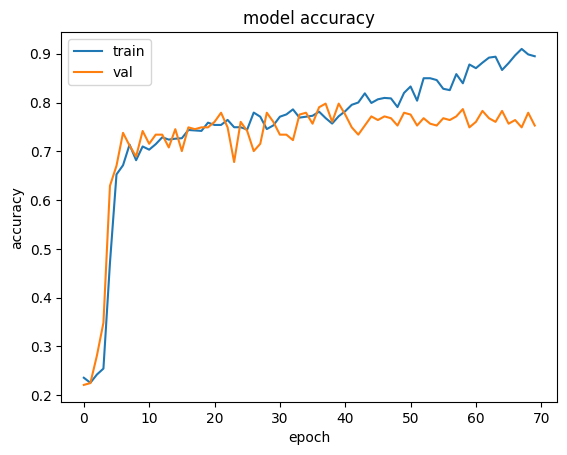

In [27]:
print(LRCN_model_training_history.history.keys())
plt.plot(LRCN_model_training_history.history['accuracy'])
plt.plot(LRCN_model_training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

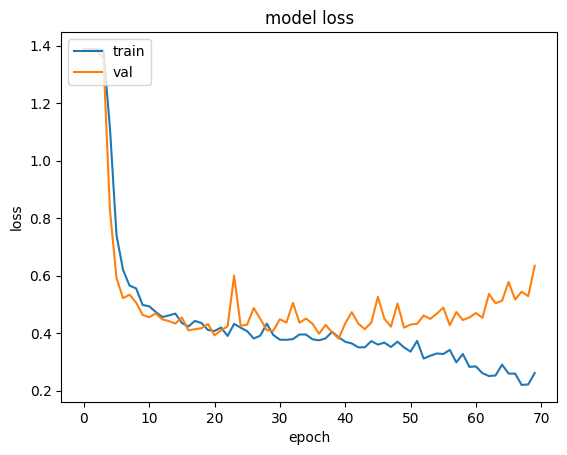

In [28]:
plt.plot(LRCN_model_training_history.history['loss'])
plt.plot(LRCN_model_training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

14/14 [==============================] - 1s 24ms/step - loss: 0.5361 - accuracy: 0.7658


In [23]:
# del LRCN_model

NameError: name 'LRCN_model' is not defined

In [19]:
Y_test = np.argmax(labels_train, axis=1)
y_pred = LRCN_model.predict_classes(features_train)
print(classification_report(Y_test, y_pred))

NameError: name 'LRCN_model' is not defined

In [30]:
def predict_on_camera():

    cam = cv2.VideoCapture(0)
    
    cam_frame_list = deque(maxlen = frame_count)

    while True:

        ok, cam_frame = cam.read()
    
        if ok == True:
        
            normalized_cam_frame = video_preprocess(cam_frame)

            cam_frame_list.append(normalized_cam_frame)

        if len(cam_frame_list) == 20:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(cam_frame_list, axis = 0))[0]
            
            for i in range(len(actions)):
                
                if predicted_labels_probabilities[i] > 0.95 and predicted_labels_probabilities[i] < 1.0:
                    
                    predicted_label = np.argmax(predicted_labels_probabilities)

                    predicted_class_name = actions[predicted_label]

                    cv2.putText(cam_frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
        cv2.imshow("Frame", cam_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cam.release()

In [31]:
while True:
    
    predict_on_camera()

KeyboardInterrupt: 